# N-BEATS

In [ ]:
pip install darts

In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (9,6)

In [5]:
df = pd.read_csv('/content/code.csv')

df.head()

date_time  traffic_volume
0  9/29/2016 17:00          5551.0
1  9/29/2016 18:00          4132.0
2  9/29/2016 19:00          3435.0
3  9/29/2016 20:00          2765.0
4  9/29/2016 21:00          2443.0

Since we are working with Darts, we need go from DataFrame to a TimeSeries object, which is the fundamental object in Darts. Every model in Darts must have a TimeSeries object as input, and it outputs a TimeSeries object as well.

<Axes: xlabel='date_time'>

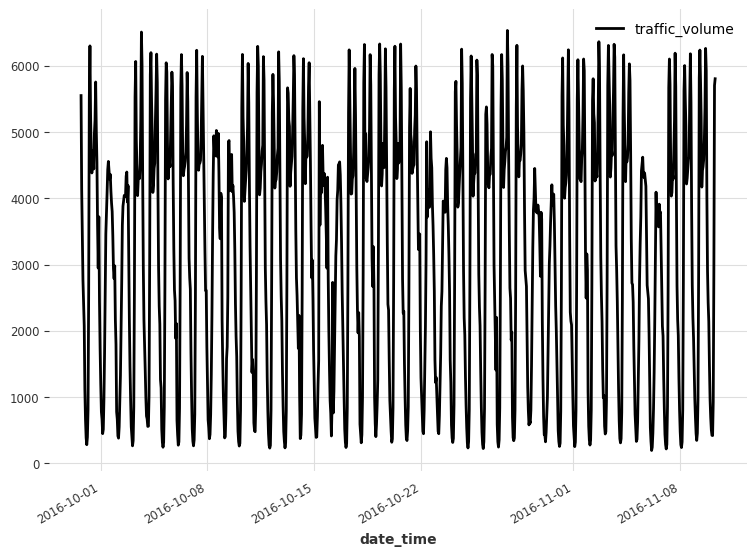

In [6]:
series = TimeSeries.from_dataframe(df, time_col='date_time')

series.plot()

Looking at the figure above, we already identify that we have two seasonal periods: *weekly and daily.* Clearly, there are more cars on the road during the day than at night, and there are more cars during the week than on the weekend.

This can actually be verified using Darts. It comes with a **check_seasonality** function that can tell us if a seasonal period has statistical significance.

In this case, since we have hourly data, a daily seasonality has a period of 24 (24 hours in a day), and a weekly seasonality has a period of 168 (24*7 hours in a week).

So, let’s make sure that both seasonal periods are significant.

In [8]:
from darts.utils.statistics import check_seasonality

is_daily_seasonal, daily_period = check_seasonality(series, m=24, max_lag=400, alpha=0.05)
is_weekly_seasonal, weekly_period = check_seasonality(series, m=168, max_lag=400, alpha=0.05)

print(f'Daily seasonality: {is_daily_seasonal} - period = {daily_period}')
print(f'Weekly seasonality: {is_weekly_seasonal} - period = {weekly_period}')

Daily seasonality: True - period = 24
Weekly seasonality: True - period = 168


**Split the data**

A natural step in a forecasting project to split our data into a training and test set. In this case, we reserve the last five days of data for the test set, and use the rest for training.

<Axes: xlabel='date_time'>

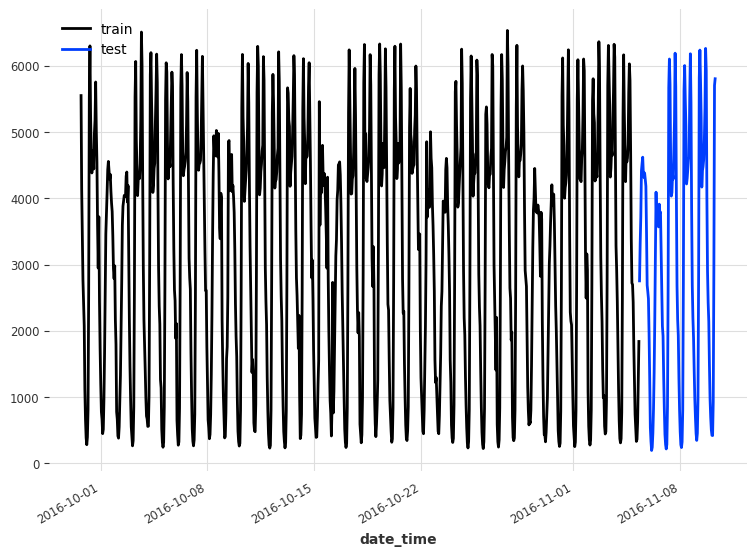

In [9]:
train, test = series[:-120], series[-120:]

train.plot(label='train')
test.plot(label='test')

**Baseline model**

Before using N-BEATS it is good to have a baseline model first. This is a simple model that serves as a benchmark to determine if a more complex model is actually better.

A baseline model usually relies on simple statistics or a simple heuristic. In this case, a naive forecasting method can be to simply repeat the last season. *Here, since we have two seasonal periods, we will use the weekly seasonality, to consider that traffic volume is lower on the weekends.*

In [10]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=168)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(120)

In the code above, we simply take the last week of data in the training set and repeat it into the future. Of course, since our forecast horizon has only five days instead of seven, we truncate the predictions at the fifth day.

Below, we can visualize the forecasts coming from the baseline model.

<Axes: xlabel='date_time'>

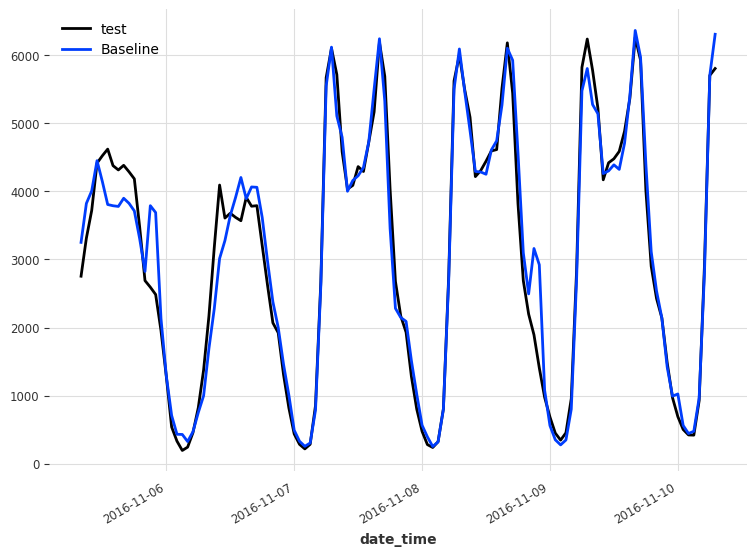

In [11]:
test.plot(label='test')
pred_naive.plot(label='Baseline')

Then, we evaluate the performance of the baseline using the mean absolute error (MAE).

In [12]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)

print(naive_mae)

249.09166666666667


This gives us a MAE of 249, and it is thus the score that we try to beat using N-BEATS.

**N-BEATS without covariates**

It's time to apply N-BEATS to the problem.

We know that we have two seasonal periods, but first we leave N-BEATS without giving it that information. We will let the model work on its own, before we help it out.

We start off by importing N-BEATS and a data scaler to speed up the training of the model.

In [14]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

We then scale our data between 1 and 0. Note that we fit the scaler on the training set only, because the model is not supposed to have information coming from the test set.

In [15]:
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

Then, we initialize the N-BEATS model. The input length will contain a full week of data, and the model will output 24h of data. In this case, we use the generic architecture.

In [16]:
nbeats = NBEATSModel(
    input_chunk_length=168,
    output_chunk_length=24,
    generic_architecture=True,
    random_state=42)

Now, we simply fit the model on the scaled training set.

In [17]:
nbeats.fit(
    scaled_train,
    epochs=50)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.3 M 
---------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
29.323    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, random_state=42)

Once the model is done training, we can forecast over the horizon of the test set. Of course, the predictions are scaled as well, so we need to reverse the transformation.

In [ ]:
scaled_pred_nbeats = nbeats.predict(n=120)

pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

Finally, we evaluate the performance of N-BEATS.

In [ ]:
mae_nbeats = mae(test, pred_nbeats)

print(mae_nbeats)

292.3977035833977


This gives a MAE of 292, which is higher than the baseline. This means that N-BEATS does not perform better than our naive predictions.

So, let’s add covariates to the model to see if we can improve its performance.

**N-BEATS with covariates**

Earlier we determined that there are two seasonal periods that are significant in our time series. We can encode that information and pass it to the model as covariates.

In other words, we add two features to the model that tells it where we are during the day and during the week. That way, the model learn that weekends have lower traffic volume, and that traffic is lower at night than during the day.

Darts conveniently comes with a an easy to achieve this using *datetime_attribute_timeseries* .

In [ ]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

cov = concatenate(
    [dt_attr(series.time_index, 'day', dtype=np.float32), dt_attr(series.time_index, 'week', dtype=np.float32)],
    axis='component'
)

We then scale the covariates too to feed it to the model.

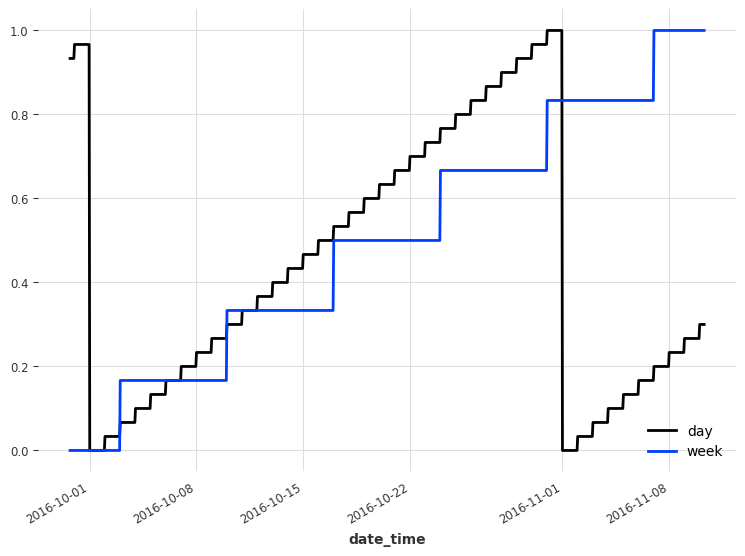

In [ ]:
cov_scaler = Scaler()

scaled_cov = cov_scaler.fit_transform(cov)

train_scaled_cov, test_scaled_cov = scaled_cov[:-120], scaled_cov[-120:]

scaled_cov.plot()

We do not need to split the covariates into a training and test set, because Darts will automatically make the appropriate split during training.

Now, we repeat the process of initializing N-BEATS and fitting it. This time, we pass the covariates as well.

In [ ]:
nbeats_cov = NBEATSModel(
    input_chunk_length=168,
    output_chunk_length=24,
    generic_architecture=True,
    random_state=42)

nbeats_cov.fit(
    scaled_train,
    past_covariates=scaled_cov,
    epochs=50
)

2022-11-22 17:05:20 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-11-22 17:05:20 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-22 17:05:20 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-22 17:05:20 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-22 17:05:21 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 10.0 M
---------------------------------------------------
10.0 M    Trainable params
4.3 K     Non-trainable params
10.0 M    Total params
79.844    Total estimated model params size (MB)


Epoch 49: 100%|██████████████████████████████████████| 22/22 [00:03<00:00,  6.29it/s, loss=0.00235, train_loss=0.00281]

2022-11-22 17:08:17 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████████████████████████████████| 22/22 [00:03<00:00,  6.29it/s, loss=0.00235, train_loss=0.00281]


Once the model is trained, we generate the predictions. *Remember to reverse the transformation again, since the predictions are scaled between 0 and 1.*

In [ ]:
scaled_pred_nbeats_cov = nbeats_cov.predict(past_covariates=scaled_cov, n=120)

pred_nbeats_cov = train_scaler.inverse_transform(scaled_pred_nbeats_cov)

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


Again, we evaluate the model’s performance using the MAE.

In [ ]:
mae_nbeats_cov = mae(test, pred_nbeats_cov)

print(mae_nbeats_cov)

287.6306614724936


This gives us a MAE of 288. This is better than not using covariates, but still worse than the baseline model.

We can also visualize our predictions:

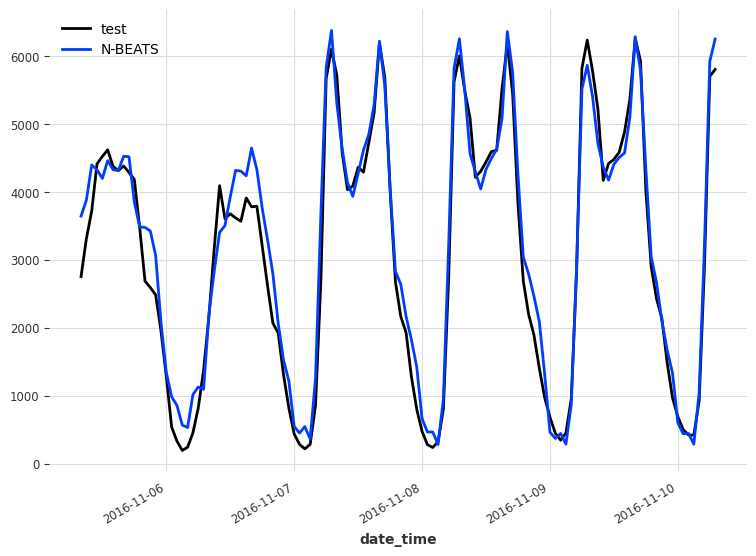

In [ ]:
test.plot(label='test')
pred_nbeats.plot(label='N-BEATS')

Just visualise the sum up of the results:

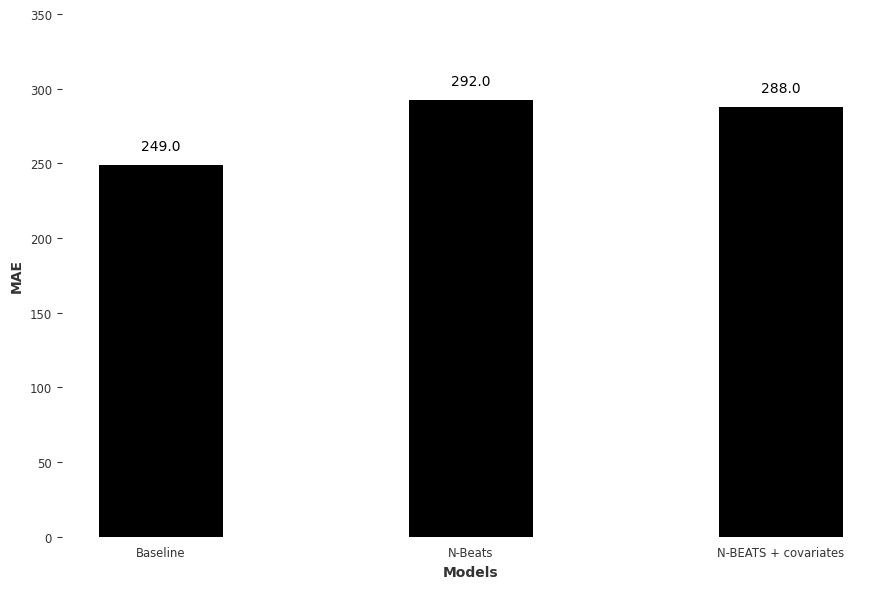

In [ ]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-Beats', 'N-BEATS + covariates']
y = [naive_mae, mae_nbeats, mae_nbeats_cov]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 350)
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 10, s=str(round(value,0)), ha='center')

plt.tight_layout()

The results obtained are less than exciting.
But we need to keep in mind that we are working with a fairly small and simple dataset. It might be that the sample is simply repetitive by nature, which explains why the baseline is so good.